In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Tuple
import numpy as np
from scipy.signal import find_peaks
from sklearn.preprocessing import StandardScaler

In [2]:
df_list = []
filename_list = []
for filename in os.listdir("data/cleaned_data"):
    df = pd.read_csv(f"data/cleaned_data/{filename}")
    filename_list.append(filename)
    df_list.append(df)
print(filename_list)

['WS23_L3_T1_P_16.csv', 'WS23_L2_T2_P_3.csv', 'WS23_L2_T1_P_4.csv', 'WS23_L1_T1_P_17.csv', 'WS23_L2_T2_P_2.csv', 'WS23_L1_T1_P_8.csv', 'WS23_L1_T1_P_21.csv', 'WS23_L1_T1_P_16.csv', 'WS23_L3_T1_P_11.csv', 'WS23_L3_T1_P_25.csv', 'WS23_L1_T1_P_5.csv', 'WS23_L3_T1_P_9.csv', 'WS23_L2_T1_P_14.csv', 'WS23_L2_T1_P_12.csv', 'WS23_L2_T2_P_4.csv', 'WS23_L2_T1_P_9.csv', 'WS23_L2_T1_P_13.csv', 'WS23_L1_T1_P_23.csv', 'WS23_L1_T1_P_14.csv', 'WS23_L2_T1_P_6.csv', 'WS23_L2_T1_P_16.csv', 'WS23_L2_T2_P_0.csv', 'WS23_L2_T1_P_2.csv', 'WS23_L1_T1_P_7.csv', 'WS23_L1_T1_P_11.csv', 'WS23_L3_T1_P_17.csv', 'WS23_L3_T1_P_4.csv', 'WS23_L2_T1_P_5.csv', 'WS23_L1_T1_P_12.csv', 'WS23_L3_T1_P_29.csv', 'WS23_L2_T1_P_8.csv', 'WS23_L1_T1_P_6.csv', 'WS23_L3_T1_P_33.csv', 'WS23_L2_T1_P_10.csv', 'WS23_L3_T1_P_32.csv', 'WS23_L3_T1_P_6.csv', 'WS23_L1_T1_P_4.csv', 'WS23_L3_T1_P_15.csv', 'WS23_L1_T1_P_15.csv', 'WS23_L3_T1_P_1.csv', 'WS23_L1_T1_P_9.csv', 'WS23_L3_T1_P_0.csv', 'WS23_L1_T1_P_3.csv', 'WS23_L3_T1_P_13.csv', 'WS23_L2_

# Find Force-Drop

In [3]:

def find_force_drop_subranges(df: pd.DataFrame, ratio: float):
    down_moves_subrange_list = []
    resistance_max = df['resistance'].max()
    curr_peak = 0
    curr_peak_idx = 0
    curr_trough_idx = 0
    for idx in range(1, len(df['resistance'])):

        if df['resistance'].iloc[idx] >= curr_peak and curr_trough_idx != curr_peak_idx:
            down_moves_subrange_list.append((curr_peak_idx, curr_trough_idx))

        if df['resistance'].iloc[idx] >= curr_peak:
            curr_peak = df['resistance'].iloc[idx]
            curr_peak_idx = idx
            curr_trough_idx = idx
        elif curr_peak - df['resistance'].iloc[idx] >= resistance_max * ratio and df['resistance'].iloc[idx] < df['resistance'].iloc[curr_trough_idx]: 
            curr_trough_idx = idx
            
    return down_moves_subrange_list

def find_largest_force_drop(df: pd.DataFrame, subrange_list: List[Tuple]):
    curr_max = 0
    for subrange_start, subrange_end in subrange_list:
        subrange_diff = df['resistance'].iloc[subrange_start] - df['resistance'].iloc[subrange_end]
        if subrange_diff > curr_max: 
            curr_max = subrange_diff
    return curr_max

def plot(df_list: List[pd.DataFrame], plot_idx_range: List[int], title: str = 'Depth vs Resistance'):
    for idx in plot_idx_range:
        print(f"plot idx: {idx}")
        df = df_list[idx]
        subranges = find_force_drop_subranges(df, 0.15)

        plt.figure(figsize=(5, 3))
        
        # Plot subrange start/end points
        for start_idx, end_idx in subranges:
            plt.plot(df['depth'].iloc[start_idx], df['resistance'].iloc[start_idx], marker='v', color='green')
            plt.plot(df['depth'].iloc[end_idx], df['resistance'].iloc[end_idx], marker='^', color='red')
        
        # Plot full depth vs resistance line
        plt.plot(df['depth'], df['resistance'],linestyle='-')
        plt.xlabel('Depth (m)')
        plt.ylabel('Resistance (N)')
        plt.title(f"{title} - Plot {idx}")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# plot(df_list, plot_idx_range=[4,14,26,31,35]+list(range(36,50)))

# Find Curve Shape

In [4]:
def find_curve_shape(df):
    x = df['depth'].to_numpy()
    y = df['resistance'].to_numpy()
    # create evenly spaces points
    chord = np.linspace(df['resistance'].iloc[0], df['resistance'].iloc[-1], num=len(df['depth']))
    y_diff = y - chord # makes chord the x-axis, any y_points above chord are pos, below are neg
    return np.trapezoid(y=y_diff, x=x)

# Choose Features

In [5]:
def extract_simple_features(df):
    res = df["resistance"]
    dep = df["depth"]
    peaks = find_peaks(df["resistance"], distance=30)[0]

    return pd.DataFrame({
        # "res_mean": [res.mean()],
        # "peaks_value": peaks[0] if len(peaks) > 0 else 0,
        "overall_slope": [res.max() / dep.max()],
        "max_depth": [dep.max()],
        "max_resistance": [res.max()],
        "num_peaks": len(peaks),
        # "num_peaks": len(find_force_drop_subranges(df,0.05)),
        "force_drop": find_largest_force_drop(df, find_force_drop_subranges(df, 0.15)),
        "curve_shape": find_curve_shape(df),
        # "force_drop_level": find_largest_force_drop(df, find_force_drop_subranges(df, 0.15))[1][0] # TODO this mess
        # "heterogeneity": heterogeneity(df, surface_fraction=0.2)
    })

# shape (n,m) where n is number of df and m is extracted feaetures
representation_list = []
for i, df in enumerate(df_list):
    extracted_simple_features = extract_simple_features(df)
    representation_list.append(extracted_simple_features)
print(f"example: {representation_list[0]}")


example:    overall_slope  max_depth  max_resistance  num_peaks  force_drop  \
0    2325.013184   0.014834       34.490185         10           0   

   curve_shape  
0     0.033168  


# Correlation Matrix

In [6]:
representation_df  = pd.concat(representation_list, axis=0, ignore_index=True)
corr_matrix = representation_df.corr()
print(corr_matrix)

                overall_slope  max_depth  max_resistance  num_peaks  \
overall_slope        1.000000  -0.662962        0.581636  -0.649210   
max_depth           -0.662962   1.000000       -0.832672   0.632644   
max_resistance       0.581636  -0.832672        1.000000  -0.693144   
num_peaks           -0.649210   0.632644       -0.693144   1.000000   
force_drop          -0.214923   0.286716       -0.172859  -0.097564   
curve_shape         -0.011220   0.142993        0.094119  -0.158466   

                force_drop  curve_shape  
overall_slope    -0.214923    -0.011220  
max_depth         0.286716     0.142993  
max_resistance   -0.172859     0.094119  
num_peaks        -0.097564    -0.158466  
force_drop        1.000000    -0.043076  
curve_shape      -0.043076     1.000000  


# Visualize Extracted Features Histograms

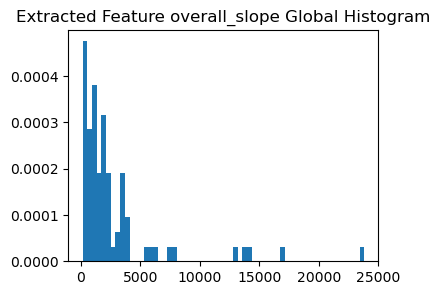

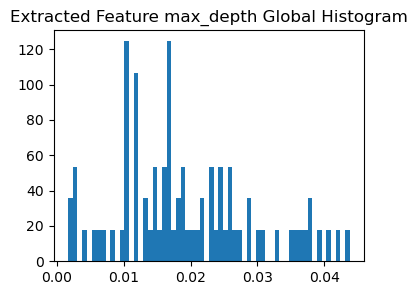

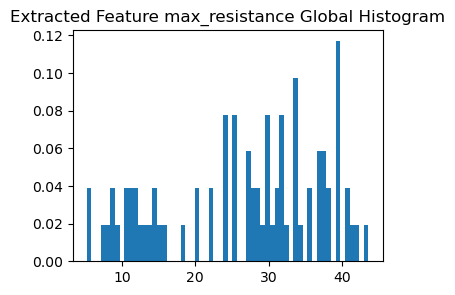

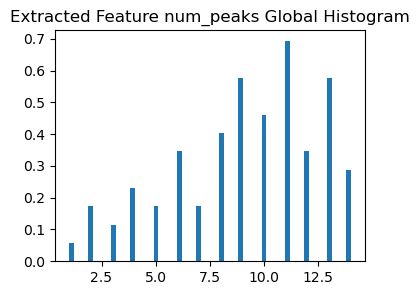

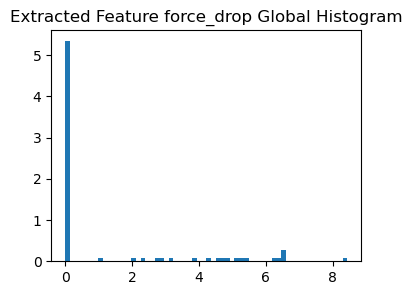

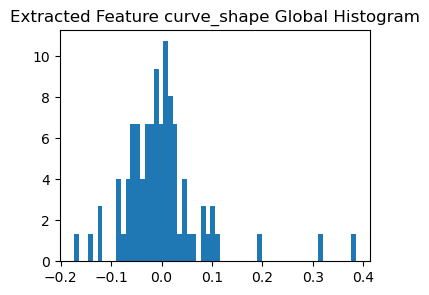

In [7]:
# representation_df  = pd.concat(representation_list, axis=0, ignore_index=True)
# # print(representation_df)
def plot_feature_dist(representation_df):
    for col in representation_df.columns:
        plt.figure(figsize=(4,3))
        plt.hist(representation_df[col], bins=60, density=True)
        plt.title(f"Extracted Feature {col} Global Histogram")
        plt.show()
plot_feature_dist(representation_df)

# Scale Features

   overall_slope  max_depth  max_resistance  num_peaks  force_drop  \
0       0.399236  -0.430733        0.729510   0.257508   -0.558874   
1       0.386714  -0.446182        0.650763   0.556067   -0.558874   
2      -0.377350   0.538862       -0.230094  -0.041052   -0.558874   
3       2.188703  -1.651172        1.221120  -1.832408   -0.558874   
4      -0.574385   0.672272       -0.577007  -0.041052    1.673589   

   curve_shape  
0     0.417062  
1    -0.588652  
2    -0.736783  
3     0.126143  
4     0.385155  


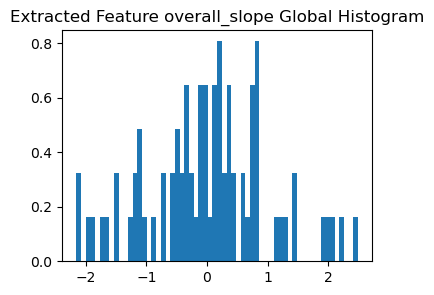

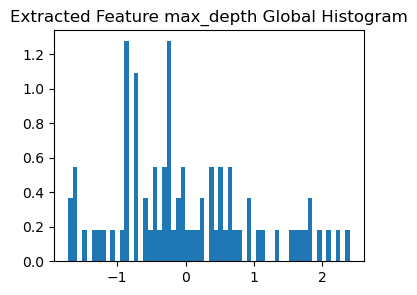

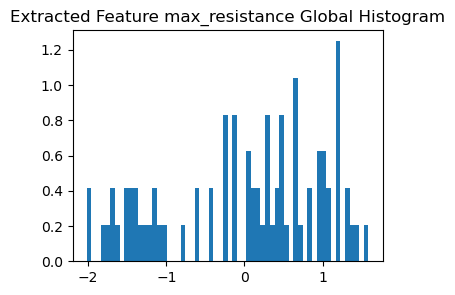

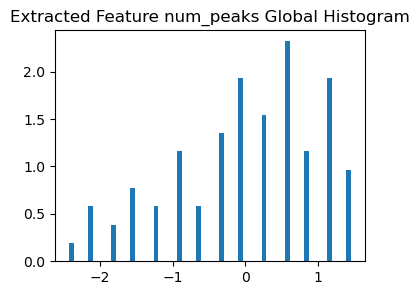

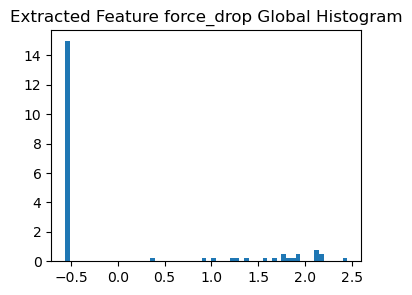

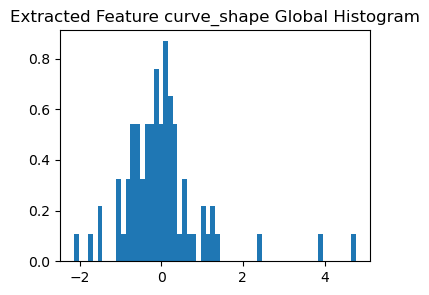

In [8]:
def transform_features(df):
    df = df.copy()  # avoid modifying original
    # Apply cube root to 'slope'
    if "overall_slope" in df.columns: df['overall_slope'] = np.log(df['overall_slope'])
    if "peaks" in df.columns: df['peaks'] = np.log(df['peaks'] + 1)
    if "peaks_value" in df.columns: df["peaks_value"] = np.log(df['peaks_value'])
    if 'force_drop' in df.columns: df['force_drop'] = np.log(df['force_drop'] + 1)
    # Standardize
    scaler = StandardScaler()
    df[df.columns] = scaler.fit_transform(df[df.columns])
    return df

scaled_representations = transform_features(representation_df)
print(scaled_representations[:5])
plot_feature_dist(scaled_representations)


# Add Metadata
- Add file names
- if labels exist add them too otherwise nan

In [9]:
scaled_representations['filenames'] = filename_list

# These are parallel arrays, ex: file WS23_L2_T1_P_3.csv is labeled as biotic crust
file_labels = ['biotic crust', 'biotic crust', 'biotic crust', 'biotic crust with surface nodules',
 'biotic crust with surface nodules', 'strata', 'strata', 'crusty ripple', 'strata', 'strata',
 'abiotic crust on top of strata', 'abiotic crust', 'strong biotic crust', 'abiotic crust',
 'abiotic crust', 'abiotic crust', 'abiotic crust', 'abiotic crust', 'strata', 'crust ripple',
 'crusty ripple', 'crusty ripple', 'crusty ripple', 'crust ripple',
 'crusty ripple', 'crusty ripple', 'crusty ripple', 'abiotic crust with surface nodule', 'crusty ripple',
 'crusty ripple', 'strata', 'strata with loose sand on top']
labeled_files = ['WS23_L2_T1_P_3.csv', 'WS23_L2_T1_P_4.csv', 'WS23_L2_T1_P_6.csv', 'WS23_L2_T1_P_7.csv', 'WS23_L2_T1_P_8.csv',
 'WS23_L2_T1_P_11.csv', 'WS23_L2_T1_P_12.csv', 'WS23_L2_T1_P_13.csv', 'WS23_L2_T1_P_14.csv', 'WS23_L2_T1_P_15.csv',
 'WS23_L2_T1_P_16.csv', 'WS23_L3_T1_P_1.csv', 'WS23_L3_T1_P_3.csv', 'WS23_L3_T1_P_4.csv', 'WS23_L3_T1_P_5.csv',
 'WS23_L3_T1_P_6.csv', 'WS23_L3_T1_P_7.csv', 'WS23_L3_T1_P_8.csv', 'WS23_L3_T1_P_9.csv', 'WS23_L3_T1_P_10.csv',
 'WS23_L3_T1_P_11.csv', 'WS23_L3_T1_P_12.csv', 'WS23_L3_T1_P_13.csv', 'WS23_L3_T1_P_15.csv', 'WS23_L3_T1_P_16.csv',
 'WS23_L3_T1_P_17.csv', 'WS23_L3_T1_P_18.csv', 'WS23_L3_T1_P_19.csv', 'WS23_L3_T1_P_20.csv', 'WS23_L3_T1_P_21.csv', 
 'WS23_L3_T1_P_22.csv', 'WS23_L3_T1_P_23.csv']

# add a label to each data point if it exists, otherwise add nan
label_map = dict(zip(labeled_files, file_labels))
scaled_representations['y_labels'] = scaled_representations['filenames'].map(label_map)

# Save representation

In [10]:
scaled_representations.to_csv(f"data/features.csv", index=False)
print(scaled_representations)

    overall_slope  max_depth  max_resistance  num_peaks  force_drop  \
0        0.399236  -0.430733        0.729510   0.257508   -0.558874   
1        0.386714  -0.446182        0.650763   0.556067   -0.558874   
2       -0.377350   0.538862       -0.230094  -0.041052   -0.558874   
3        2.188703  -1.651172        1.221120  -1.832408   -0.558874   
4       -0.574385   0.672272       -0.577007  -0.041052    1.673589   
..            ...        ...             ...        ...         ...   
75       2.487856  -1.716791        1.192975  -2.429527   -0.558874   
76      -0.036923   0.687849        1.021691  -2.130968   -0.558874   
77      -0.372677  -0.690985       -1.379584   0.556067   -0.558874   
78      -1.872830   2.231655       -1.771156   1.153186    0.908308   
79      -0.471793   1.158234        0.066853  -1.235290    1.919260   

    curve_shape            filenames                           y_labels  
0      0.417062  WS23_L3_T1_P_16.csv                      crusty ripple  